# Initial setup

Let's import the required libraries and set up global variables for the rest of the script.

In [1]:
# coding: utf-8
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import mpld3
import os
%matplotlib inline

import networkx as nx

Helper function to create a directory under the specified path, gracefully handling errors.

In [2]:
def __mkdir(*args):
    path = os.path.join(*args)
    try: 
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise
    return path

In [3]:
# Create the project directory holding the downloaded data, serialized dataframes and MetaMap install.
# working_dir = __mkdir(os.path.expanduser("~"), "Medframes")

# Set working directory as the current directory of the ipython notebook
working_dir = os.getcwd()
data_dir = __mkdir(working_dir, "data")
print("Working directory: %s" % working_dir)

Working directory: /Users/Lo/Work/CS109Project


# Load MetaMap & MedEx processing results

In [4]:
mm = pd.read_pickle(os.path.join(data_dir, 'mm.pckl'))
mm.head()

,ngram,nct_id,criteria_id,ngram_index,score,term,cui,stype,cid
0,"((time, NN),)",NCT00001149,0,0,8.34,Time,C0040223,tmco,[G01.910]
1,"((uncontrolled, VBN), (seizure, NNS), (at, IN))",NCT00001149,0,8,16.21,Seizures,C0036572,sosy,"[C10.228.140.490.631, C10.597.742, C23.888.592..."
2,"((of, IN), (seizure, NNS), (during, IN))",NCT00001149,0,10,16.21,Seizures,C0036572,sosy,"[C10.228.140.490.631, C10.597.742, C23.888.592..."
3,"((seizure, NNS), (at, IN), (the, DT))",NCT00001149,0,11,16.21,Seizures,C0036572,sosy,"[C10.228.140.490.631, C10.597.742, C23.888.592..."
4,"((pattern, NN), (of, IN), (seizure, NNS))",NCT00001149,0,12,16.07,Seizures,C0036572,sosy,"[C10.228.140.490.631, C10.597.742, C23.888.592..."


In [44]:
medex = pd.read_pickle(os.path.join(data_dir, 'medex.pckl'))
medex.head()

,nct_id,criteria_id,drug_name,drug_form,strength,dose,route,frequency,duration,cui,generic_name,term
0,NCT00001205,8,corticosteroid,,,,,,,,corticosteroid,corticosteroid
1,NCT00001205,8,immunosuppressive,,,,,,,,immunosuppressive,immunosuppressive
2,NCT00001205,11,praziquantel,,,,,,,C0032911,praziquantel,praziquantel
3,NCT00001205,11,albendazole,,,,,,,C0001911,albendazole,albendazole
4,NCT00001205,11,methotrexate,,,,,,,C0025677,methotrexate,methotrexate


# Merging datasets by criteria_id

In [45]:
merged = pd.merge(mm, medex, on=['criteria_id', 'nct_id'], how='right')
merged.to_pickle(os.path.join(data_dir, 'merged.pckl'))
merged.head()

,ngram,nct_id,criteria_id,ngram_index,score,term_x,cui_x,stype,cid,drug_name,drug_form,strength,dose,route,frequency,duration,cui_y,generic_name,term_y
0,"((immunosuppressive, NNS), (other, JJ), (than,...",NCT00001205,8,0,16.21,Immunosuppressive Agents,C0021081,"imft,phsu",[D27.505.696.477.656],corticosteroid,,,,,,,,corticosteroid,corticosteroid
1,"((for, IN), (therapy, NN))",NCT00001205,8,2,22.57,therapeutic aspects,C0039798,ftcn,[x.x.x.x.x.x.x],corticosteroid,,,,,,,,corticosteroid,corticosteroid
2,"((patient, NNS),)",NCT00001205,8,3,8.34,Patients,C0030705,podg,[M01.643],corticosteroid,,,,,,,,corticosteroid,corticosteroid
3,"((child, NNP),)",NCT00001205,8,4,11.49,Child,C0008059,aggp,[M01.060.406],corticosteroid,,,,,,,,corticosteroid,corticosteroid
4,"((corticosteroid, NNS),)",NCT00001205,8,5,11.49,Adrenal Cortex Hormones,C0001617,"horm,phsu,strd",[D06.472.040],corticosteroid,,,,,,,,corticosteroid,corticosteroid


In [46]:
merged = pd.read_pickle(os.path.join(data_dir, 'merged.pckl'))
dfconn = merged.loc[:, ['term_x', 'term_y']]
dfconn.term_y = dfconn['term_y'].str.upper()
dfconn.term_x = dfconn['term_x'].str.lower()
dfconn.term_y = dfconn['term_y'].str.replace(",", ' ').str.replace("'", " " )
dfconn.term_x = dfconn['term_x'].str.replace(",", ' ').str.replace("'", " ")
dfconn = dfconn.rename(columns={'term_x': 'mm', 'term_y': 'md'})
dfconn.to_pickle(os.path.join(data_dir, 'mm-medex-terms.pckl'))
dfconn.head()

,mm,md
0,immunosuppressive agents,CORTICOSTEROID
1,therapeutic aspects,CORTICOSTEROID
2,patients,CORTICOSTEROID
3,child,CORTICOSTEROID
4,adrenal cortex hormones,CORTICOSTEROID


In [8]:
dfconn = pd.read_pickle(os.path.join(data_dir, 'mm-medex-terms.pckl'))

In [47]:
def vis_prep(df, threshhold=0.1, start=0, finish=10):
    
    # key: node, value: count (total)
    mm_nodes, md_nodes, edges = {},{},{}
    mm_n = dict(np.sqrt(df.mm.value_counts()))
    md_n = dict(np.sqrt(df.md.value_counts())*4)
    
    # remove plural in mm tag
    for k in mm_nodes.keys():
        if k.endswith("s") and k[:-1] in mm_nodes.keys():
            mm_nodes[k[:-1]] += mm_nodes[k]
            mm_nodes.pop(k)
    
    for d in df.md.unique()[start:finish]:
        
        counted = df[df.md==d].mm.value_counts()
        
        # remove medex key in items (including plural forms)
        mask = []
        for i in counted.index:
            mask.append(False) if i in d.lower() or i.rstrip("s") in d.lower() else mask.append(True)
        counted=counted[mask]
        
        # convert count to to % in total
        conv = counted/float(sum(counted))
        
        # filter out terms above threshhold, convert to dict, *100 as edge width
        conv = dict(conv[conv>threshhold]*10)
        
        
        #only add to node list if not empty
        if len(conv) > 0:
            md_nodes[d] = md_n[d]

            #convert key to edge (m, d)    
            for i in conv.keys():
                edges[(d,i)] = conv.pop(i)
                mm_nodes[i] = mm_n[i]
        
    return mm_nodes,md_nodes,edges

In [48]:
def draw_mm_medex_vis(mm_nodes, md_nodes, edges, interactive=True):
    G = nx.Graph()
    fig, ax = plt.subplots(figsize=(12,8))

    for node, size in mm_nodes.iteritems():
        G.add_node(node, cat="mm", s=size)
    
    for node, size in md_nodes.iteritems():
        G.add_node(node, cat="md", s=size)
    
    for (p1,p2), width in edges.iteritems():
        G.add_edge(p1,p2)#, w=width)
    
    color_map = {'md':'r', 'mm':'b'}
    pos = nx.graphviz_layout(G, prog="neato")
    nx.draw_networkx_edges(G, pos, alpha=0.2, ax=ax)#, width=[G.edge[edge]['w'] for edge in G])
    scatter = nx.draw_networkx_nodes(G, pos, alpha=0.6, ax=ax, 
                                     node_color=[color_map[G.node[node]['cat']] for node in G], 
                                     node_size =[G.node[node]['s'] for node in G])
    ax.set_title(str(len(md_nodes))+" MedEx tags (Red) and " + str(len(mm_nodes)) + " connected MetaMap tags (Blue)")
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
    if interactive:
        ax.set_xlabel('(Interactive)')
        labels = G.nodes()
        tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
        mpld3.plugins.connect(fig, tooltip)
        mpld3.enable_notebook()
    else:
        #plt.savefig("mm-md.png")
        plt.show()

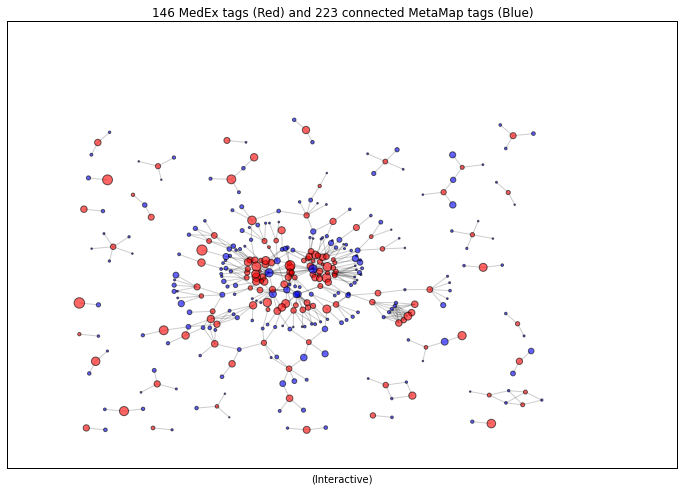

In [49]:
mm_nodes,md_nodes,edges = vis_prep(dfconn, start=100, finish=300)
draw_mm_medex_vis(mm_nodes, md_nodes, edges)

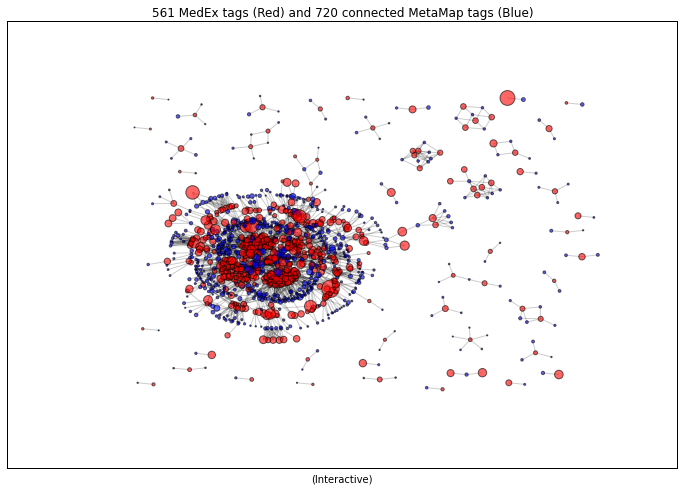

In [50]:
mm_nodes,md_nodes,edges = vis_prep(dfconn, start=None, finish=None)
draw_mm_medex_vis(mm_nodes, md_nodes, edges)